In [322]:
from random import random
from random import randint
from random import choice
from numpy import array
from numpy import zeros
import numpy as np
from keras.preprocessing.sequence import pad_sequences

In [990]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.optimizers import RMSprop

In [1131]:
def check_in_frame ( size, pos ):
    """
    Allow space around the shape
    """
    if 0 <= pos[0] < size and  0 <= pos[1] < size:
        return True
    return False

def check_in_frame_with_space ( size, pos ):
    """
    Allow space around the shape
    """
    if 1 <= pos[0] < size - 1 and  1 <= pos[1] < size - 1:
        return True
    return False

class Shape ( object ):
    """
    Shape is actually just a frame of size x size
    have some imprinted grey shape
    and a  list of inner points
    """
    
    def __init__ ( self, frame, inside_points ):
        self.frame = frame
        self.inside_points = inside_points
        
    
def generate_u_shape ( frame, bottom, left, right, direction, position ):
    """
    Impose an U shape structure on the frame, position is where you start it (top-left corner of rectangle)
    
    This is an U-shape with bottom = 4, left = 4, right = 3, direction = 0
    S
    o x x o
    o x x o
    o o o o
    
    direction = 2
    
    S o o o 
    o x x 
    o x x 
    o o o
    
    direction = 2
    
    S o o o
    o x x o
    o x x o
    o 
    
    # Let consider this case in a later phase
    This is an U-shape with bottom = 4, left = 4, right = 3, direction = 1
    
            o
          o
        o x
      o x x x
        o x x x o
          o x o
            o
    We can start with even direction first ( 0 (North), 2 (East), 4 (South), 6(West) )
    The positions marked with x are the positions that are considered inside the U-shape
    
    This function returns whether imposition successes, and frame would be imposed with the U-shape
    
    Parameters:
    =====================
    frame: squared frame
    bottom: integer value
    left: integer value
    right: integer value
    direction: 
    position: tuple of 2
    
    Returns:
    =====================
    - success: whether imposition successes or not
    - shape: contains the frame and inside points
    
    """
    size = frame.shape[0]
    
    if direction == 0 or direction == 4:
        other_corner = ( position[0] + max(left, right) - 1, position[1] + bottom - 1 )
        
    if direction == 2 or direction == 6:
        other_corner = ( position[0] + bottom - 1, position[1] + max(left, right) - 1 )

    if not check_in_frame_with_space ( size, position) or not check_in_frame_with_space ( size, other_corner ):
#         s = Shape ( frame, ( [], [] ) )
        return False, ( [], [] )
    
    # Let's create one U-shape that has a direction == 0, than we rotate it
    inner_shape = np.zeros((max(left, right), bottom))
    # Left side
    for i in range (max(left, right)):
        inner_shape[i,0] = 1
    
    # Right side
    for i in range (max(left, right) - min(left, right), max(left, right)):
        inner_shape[i,bottom - 1] = 1
    
    # Bottom side
    for i in range (bottom):
        inner_shape[max(left, right) - 1,i] = 1
        
    for i in range(max(left, right) - min(left, right), max(left, right) - 1):
        for j in range(1, bottom - 1):
            inner_shape[i,j] = 2
    
    rotated_shape = np.rot90 ( inner_shape, -direction // 2 )
    
    
    frame[ position[0] : position[0] + rotated_shape.shape[0], 
          position[1] : position[1] + rotated_shape.shape[1] ] = rotated_shape
    
    inside_points = np.where(frame == 2)
    
    frame[frame == 2] = 0
    
#     s = Shape ( frame, inside_points )
    
    return True, inside_points


In [66]:
def check_in_range (value, bottom, left, right, direction, position ):
    """
    bottom, left, right, direction, position is the parameters of U-shape
    
    value is a coordinates (x, y)
    """
    if direction == 0 or direction == 4:
        if position[0] <= value[0] <= position[0] + max(left, right) and position[1] <= value[1] <= position[1] + bottom:
            return True
    
    if direction == 2 or direction == 6:
        if position[0] <= value[0] <= position[0] + bottom and position[1] <= value[1] <= position[1] +  max(left, right):
            return True
    
    return False

In [55]:
a = np.ones((2,3))
np.where(a == 1)

(array([0, 0, 0, 1, 1, 1], dtype=int64),
 array([0, 1, 2, 0, 1, 2], dtype=int64))

In [58]:
f = zeros ((10, 10))
generate_u_shape (f , 4, 4, 3, 4, (5,4) )

(True, (array([6, 6, 7, 7], dtype=int64), array([5, 6, 5, 6], dtype=int64)))

In [59]:
f

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [861]:
def generate_u_shape_frame ( size, bottom_range = list(range(3,5)), 
                  left_range = list(range(3,5)), right_range = list(range(3,5)), 
                  direction_range = list(range(0,8,2)) ):
    frame = zeros((size, size))
    
    # You random a value in those range to add into the frame
    # You also
    bottom = choice(bottom_range)
    left = choice(left_range)
    right = choice(right_range)
    direction = choice(direction_range)
    while True:
        position_x = randint ( 0, size - 1 )
        position_y = randint ( 0, size - 1 )
        position = (position_x, position_y)

        success, inner_list = generate_u_shape  ( frame, bottom, left, right, direction, position )
        
        if success : 
            break
    
    # Random outer position for moving point
    while True:
        pos_start_x = randint ( 0, size - 1 )
        pos_start_y = randint ( 0, size - 1 )
        
        pos_start = (pos_start_x, pos_start_y)
        
        # Just need to be out of the rectangle
        if check_in_range ( pos_start, bottom, left, right, direction, position ):
            continue
            
        break
    
    # Random inner position for moving point
    index = randint ( 0, len(inner_list[0]) - 1 )
    pos_end = (inner_list[0][index], inner_list[1][index])
    
    return frame, pos_start, pos_end

In [381]:
frame, pos_start, pos_end = generate_u_shape_frame ( 10 )

In [382]:
frame

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [131]:
pos_start

(7, 9)

In [135]:
pos_end

(4, 4)

In [138]:
def get_neighbors ( size, pos ):
    neighbors = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (i == 0 or j == 0) and not i == j == 0:
                new_pos = (pos[0] + i, pos[1] + j)
                if check_in_frame ( size, new_pos ):
                    neighbors.append(new_pos)
    return neighbors
    

def generate_path ( frame, pos_start, pos_end ):
    size = frame.shape[0]
    # Keep track of the previous cell that has been expanded to
    parent = {}
    
    ### There is nothing too difficult here, we run overflow algorithm to cover the space
    f = frame.copy()
    f[pos_start] = 2
    f[pos_end] = 3
    
    explore_list = [ pos_start ]
    
    def search ( l ):
        while l:
            # Get the shortest path to the pos_end
            new_explore_list = []

            for pos in l:
                for n in get_neighbors( size, pos ):
                    if f[n] == 3:
                        # Found
                        parent[n] = pos
                        return
                    if f[n] == 0:
                        # Add into new list
                        new_explore_list.append(n)
                        parent[n] = pos
                        # 4 is marked
                        f[n] = 4
            l = new_explore_list
        
    
    search ( explore_list )
    cur = pos_end
    
    path = []
    while cur in parent:
        path.append(cur)
        cur = parent[cur]
    
    path.append(cur)
    return path[::-1]

In [139]:
generate_path ( frame, pos_start, pos_end )

[(7, 9), (6, 9), (5, 9), (4, 9), (4, 8), (4, 7), (4, 6), (4, 5), (4, 4)]

In [349]:
def build_frames(size, env_generator ):
    frames = list()
    # create the first frame
    frame, pos_start, pos_end = env_generator ( size )
    
    # If it is enter (enter = 1): start with pos_start, end with pos_end
    # If it is exit (exit = 1): start with pos_end, end with pos_start
    r = random()
    print (r)
    enter = 1 if r < 0.5 else 0
    
    if enter == 0:
        pos_start, pos_end = (pos_end, pos_start)
        
    path = generate_path ( frame, pos_start, pos_end )
    
    for step in path:
        f = frame.copy()
        f[step] = 1
        frames.append(f)
        
    return frames, enter

In [160]:
from matplotlib import pyplot

0.43449652360631996
Enter
15


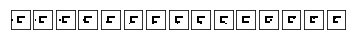

In [383]:
size = 12
frames, enter = build_frames(size, lambda size: generate_u_shape_frame(size, bottom_range = list(range(3,6)), 
                  left_range = list(range(3,6)), right_range = list(range(3,6)) ))
if enter == 1:
    print ('Enter')
else:
    print ('Exit')
    
print (len(frames))
# plot all frames
pyplot.figure()
for i in range(len(frames)):
    # create a gray scale subplot for each frame
    pyplot.subplot(1, len(frames), i + 1)
    pyplot.imshow(frames[i], cmap='Greys')
    # turn of the scale to make it clearer
    ax = pyplot.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# show the plot
pyplot.show()

In [660]:
def pad_frames ( frames, length, padding_start = False  ):
    if len(frames) > length:
        """
        Randomly drop some frames, just not the first and last ones
        """
        while len(frames) > length:
            drop_index = randint(1, len(frames) - 2)
            frames.pop(drop_index)
            
    if len(frames) < length:
        if padding_start:
            frames = [frames[0]] * (length - len(frames)) + frames
        else:
            frames = frames + [frames[-1]] * (length - len(frames))
    return frames

In [766]:
def build_frames_pad(size, length, env_generator, padding_start = False, enter = None ):
    """
    Limit the length of the session, or adding cloned frame if needed
    """
    frames = list()
    # create the first frame
    frame, pos_start, pos_end = env_generator ( size )
    if frame is None:
        return None, None, None
    
    if enter is None:
        """
        enter hasn't been set, randomize it
        """
        # If it is enter (enter = 1): start with pos_start, end with pos_end
        # If it is exit (exit = 1): start with pos_end, end with pos_start
        r = random()
        enter = 1 if r < 0.5 else 0
    
    if enter == 0:
        pos_start, pos_end = (pos_end, pos_start)
        
    path = generate_path ( frame, pos_start, pos_end )
    
    for step in path:
        f = frame.copy()
        f[step] = 4
        frames.append(f)
        
    real_len = len(frames)
    
    if padding_start is not None:
        frames = pad_frames ( frames, length, padding_start )
        
    return frames, enter, real_len

In [656]:
frames, enter, real_len = build_frames_pad(size, 10, lambda size: generate_u_shape_frame(size, bottom_range = list(range(3,6)), 
                  left_range = list(range(3,6)), right_range = list(range(3,6)) ))

In [592]:
print (len(frames))

10


In [787]:
def plot( sample , l = None):
    if l is None:
        l = len (sample)
    sample = array(sample)
    sample = sample.reshape(sample.shape[0], sample.shape[1], sample.shape[2], 1)
    pyplot.figure()
    for i in range(len(sample)):
        # create a gray scale subplot for each frame
        pyplot.subplot(1, l, i + 1)
        pyplot.imshow(sample[i,:,:,0], cmap='Greys')
        # turn of the scale to make it clearer
        ax = pyplot.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    # show the plot
    pyplot.show()

In [668]:
# generate multiple sequences of frames and reshape for network input
def generate_examples(size, length, n_patterns, env_generator):
    X, y = list(), list()
    while len(X) < n_patterns:
        frames, enter, real_len = build_frames_pad(size, length, env_generator)
        if not frames is None:
            X.append(frames)
            y.append(enter)
    
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, length, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

In [669]:
X, y = generate_examples(12, 15, 100, shape_generator)

In [791]:
def plot_big(sample):
    for i in range( len(sample) // 5 + 1):
        plot(sample[5 * i:min(len(sample), 5 * i + 5)], l = 5)

In [684]:
y_progress[t]

array([[0.   ],
       [0.125],
       [0.25 ],
       [0.375],
       [0.5  ],
       [0.625],
       [0.75 ],
       [0.875],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ],
       [1.   ]])

In [287]:
print (X.shape)

(20000, 15, 12, 12, 1)


In [991]:
# configure problem
# define the model
class Classifier ( object ):
    def __init__ (self):
        self.model = Sequential()
        self.model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu'),
        input_shape=(None,size,size,1)))
        self.model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        self.model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu'),
        input_shape=(None,size,size,1)))
        self.model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        self.model.add(TimeDistributed(Flatten()))

        self.model.add(LSTM(100))
        self.model.add(Dense(1, activation='sigmoid'))

        opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
        
        self.model.compile(loss='binary_crossentropy', optimizer = opt , metrics=['acc'])
        print(self.model.summary())

c = Classifier ()
c.model.fit(X, y, batch_size=50, epochs=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_230 (TimeDi (None, None, 11, 11, 4)   20        
_________________________________________________________________
time_distributed_231 (TimeDi (None, None, 5, 5, 4)     0         
_________________________________________________________________
time_distributed_232 (TimeDi (None, None, 4, 4, 4)     68        
_________________________________________________________________
time_distributed_233 (TimeDi (None, None, 2, 2, 4)     0         
_________________________________________________________________
time_distributed_234 (TimeDi (None, None, 16)          0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 100)               46800     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total para

ValueError: Input arrays should have the same number of samples as target arrays. Found 3 input samples and 100 target samples.

In [598]:
shape_generator = lambda size: generate_u_shape_frame(size, bottom_range = list(range(3,6)), 
                  left_range = list(range(3,6)), right_range = list(range(3,6)) )
# evaluate model
X_evaluate, y_evaluate = generate_examples(size, 15, 100, shape_generator)
loss, acc = model.evaluate(X_evaluate, y_evaluate, verbose=0)
print('loss: %f, acc: %f' % (loss, acc*100))
# prediction on new data
X_test, y_test = generate_examples(size, 15, 1, shape_generator)
yhat = model.predict_classes(X_test, verbose=0)
expected = "Enter" if y_test[0]==1 else "Exit"
predicted = "Enter" if yhat[0]==1 else "Exit"
print('Expected: %s, Predicted: %s' % (expected, predicted))

loss: 0.100671, acc: 96.000000
Expected: Enter, Predicted: Enter


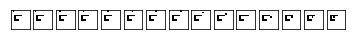

In [323]:
plot(X_evaluate[0])

In [721]:
# generate multiple sequences of frames and reshape for network input
def generate_example_progress(size, length, n_patterns, env_generator, enter = True ):
    """
    size: size of the problem (size of image)
    """
    X, y = list(), list()
    while len(X) < n_patterns:
        frames, _, real_len = build_frames_pad(size, length, env_generator, padding_start = None, enter = enter)
        if not frames is None:
            X.append(frames)
            
            if real_len < len(frames):
                progress = np.concatenate ( [ np.linspace(0, 1, num=real_len) , [1] * ( len(frames) - real_len ) ] )
            else:
                progress = np.linspace(0, 1, num=len(frames))
            y.append(progress)
    
    # resize as [samples, timesteps, width, height, channels]

    X = array(X).reshape(n_patterns, length, size, size, 1)
    y = array(y).reshape(n_patterns, length, 1)
    return X, y

In [727]:
from collections import defaultdict
def generate_example_progress_diff_len(size, length, n_patterns, env_generator, enter = True ):
    """
    Same as generate_example_progress but return different List of X,y for different length
    """
    X, y = defaultdict(list), defaultdict(list)
    
    total = 0
    while total < n_patterns:
        frames, _, real_len = build_frames_pad(size, length, env_generator, padding_start = None, enter = enter)
        if not frames is None:
            progress = np.linspace(0, 1, num=len(frames))
                
            X[len(frames)].append(frames)
            y[len(frames)].append(progress)
            total += 1
    
    for key in X:
        # resize as [samples, timesteps, width, height, channels]
        X[key] = array(X[key]).reshape(len(X[key]), key, size, size, 1)
        y[key] = array(y[key]).reshape(len(y[key]), key, 1)
    
    samples = []
    for key in sorted(X.keys()):
        samples.append( (X[key], y[key] ) )
        
    return samples

In [708]:
X, y_progress = generate_example_progress(12, 15, 20000, shape_generator)

In [1158]:
samples = generate_example_progress_diff_len(12, 15, 50000, shape_generator)

In [879]:
import math
def generate_negative_sample ( sample_X, sample_Y ):
    """
    For data (frames) of a sample, generate a negative sample, which is a "divergence"
    of the original positive sample.
    Let's do the simplest form, which just walk backward after we have run for half the distance
    
    Parameters:
    - sample_X ( len, size, size, 1 )
    - sample_Y ( len, 1)    
    """
    # Should equal sample_Y.shape[0] as well
    l = sample_X.shape[0]
    
    ceil = int( math.ceil ( l / 2 ))
    floor = int( math.floor ( l / 2 ))
    
    # I need to diverge from the current direction
    # The simplest thing is to walk backward
    
    new_sample_X = np.concatenate( [ sample_X[:ceil, :, :, :], sample_X[floor: 0 : -1, :, :, :] ] )
    new_sample_Y = np.concatenate( [ sample_Y[:ceil, :], sample_Y[floor: 0 : -1, :] ] )
    
    return (new_sample_X, new_sample_Y)

In [867]:
a = [ 2,3,4,5,6,7]
print (a[-1:2:-1])

[7, 6, 5]


In [1178]:
class Progress ( object ):
    def __init__ (self):
        self.model = Sequential()
        self.model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu'),
        input_shape=(None,size,size,1)))
        self.model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        self.model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu'),
        input_shape=(None,size,size,1)))
        self.model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        self.model.add(TimeDistributed(Flatten()))
        
        self.model.add(LSTM(100, return_sequences=True))
#         self.model.add(LSTM(200, return_sequences=True))
        self.model.add(Dense(1, activation='sigmoid'))

#         opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

        # RMSProp with lr == 0.001 and LSTM = 50 nodes seems pretty good
        opt = RMSprop(lr=0.001)
        self.model.compile(loss='mean_squared_error', optimizer = opt)
        print(self.model.summary())

c = Progress ()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_255 (TimeDi (None, None, 11, 11, 4)   20        
_________________________________________________________________
time_distributed_256 (TimeDi (None, None, 5, 5, 4)     0         
_________________________________________________________________
time_distributed_257 (TimeDi (None, None, 4, 4, 4)     68        
_________________________________________________________________
time_distributed_258 (TimeDi (None, None, 2, 2, 4)     0         
_________________________________________________________________
time_distributed_259 (TimeDi (None, None, 16)          0         
_________________________________________________________________
lstm_55 (LSTM)               (None, None, 100)         46800     
_________________________________________________________________
dense_52 (Dense)             (None, None, 1)           101       
Total para

In [1159]:
"""
========================================= ADD NEGATIVE SAMPLES ===========================================

"""
for index in range(len(samples)):
    X, y_progress = samples[index]
    l = X[0].shape[0]
    if 6 <= l <= 16:
        print (l)
        new_X_s = []
        new_Y_s = []
        for i in range(len(X)):
            new_X, new_Y = generate_negative_sample ( X[i], y_progress[i] )
            new_X_s.append( new_X )
            new_Y_s.append( new_Y )
            
        new_X_s = array(new_X_s).reshape(len(new_X_s), l, size, size, 1)
        new_Y_s = array(new_Y_s).reshape(len(new_Y_s), l, 1)
        
        samples[index] = ( np.concatenate([X, new_X_s]), np.concatenate([y_progress, new_Y_s]) )
    

6
7
8
9
10
11
12
13
14
15
16


In [1184]:
"""
============================================== TRAINING ==================================================

"""
            
for epoch in range(2):
    print ('------------------------')
    print (epoch)
    for X, y_progress in samples:
        if 6 <= X[0].shape[0] < 8:
            print (X[0].shape[0])
            h = c.model.fit(X, y_progress, batch_size=50, epochs=3)
        if 8 <= X[0].shape[0] < 10:
            print (X[0].shape[0])
            h = c.model.fit(X, y_progress, batch_size=50, epochs=2)
#         if 10 <= X[0].shape[0] <= 16:
#             print (X[0].shape[0])
#             h = c.model.fit(X, y_progress, batch_size=50, epochs=1)

------------------------
0
6
Epoch 1/3
4606/4606 [==============================] - 2s 492us/step - loss: 0.0204
Epoch 2/3
4606/4606 [==============================] - 2s 496us/step - loss: 0.0014
Epoch 3/3
4606/4606 [==============================] - 2s 502us/step - loss: 9.2543e-04
7
Epoch 1/3
6478/6478 [==============================] - 4s 545us/step - loss: 9.1221e-04
Epoch 2/3
6478/6478 [==============================] - 4s 549us/step - loss: 6.8408e-04
Epoch 3/3
6478/6478 [==============================] - 4s 555us/step - loss: 6.0077e-04
8
Epoch 1/2
7882/7882 [==============================] - 5s 593us/step - loss: 5.8266e-04
Epoch 2/2
7882/7882 [==============================] - 5s 602us/step - loss: 4.5721e-04
9
Epoch 1/2
9166/9166 [==============================] - 6s 650us/step - loss: 4.5038e-04
Epoch 2/2
9166/9166 [==============================] - 6s 652us/step - loss: 3.7140e-04
------------------------
1
6
Epoch 1/3
4606/4606 [==============================] - 2s 494us/

In [1181]:
print (c.model.optimizer.lr)

<tf.Variable 'RMSprop_5/lr:0' shape=() dtype=float32_ref>


In [1185]:
test_samples = generate_example_progress_diff_len(12, 15, 500, shape_generator)
total_sample = 0
total_loss = 0
for X_evaluate, y_progress_evaluate in test_samples:
    print ('Shape = %d' % X_evaluate[0].shape[0])
    if 6 <= X_evaluate[0].shape[0] <= 16:
        total_sample += len(X_evaluate)
        loss = c.model.evaluate(X_evaluate, y_progress_evaluate, verbose=2)
        total_loss += loss * len(X_evaluate)
        print('sample: %d, loss: %f' % (len(X_evaluate), loss))
print('Total loss: %f' % (total_loss / total_sample))

Shape = 3
Shape = 4
Shape = 5
Shape = 6
sample: 21, loss: 0.057170
Shape = 7
sample: 39, loss: 0.024834
Shape = 8
sample: 30, loss: 0.006574
Shape = 9
sample: 58, loss: 0.000569
Shape = 10
sample: 45, loss: 0.004455
Shape = 11
sample: 53, loss: 0.013467
Shape = 12
sample: 40, loss: 0.021774
Shape = 13
sample: 44, loss: 0.039103
Shape = 14
sample: 38, loss: 0.059659
Shape = 15
sample: 38, loss: 0.106547
Shape = 16
sample: 32, loss: 0.124411
Shape = 17
Shape = 18
Shape = 19
Shape = 20
Shape = 21
Shape = 24
Total loss: 0.036991


In [1169]:
predicted = c.model.predict(test_samples[3][0][:1])
print (predicted.flatten())
print (test_samples[3][1][:1].flatten())

[0.00634135 0.06809177 0.13865402 0.20430864 0.26404908 0.32448518]
[0.  0.2 0.4 0.6 0.8 1. ]


In [764]:
test_samples[2][1][:1].flatten()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

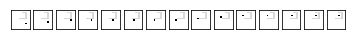

In [691]:
plot(X_evaluate[0])

In [450]:
def generate_jar_shape ( frame, width, height, bulb, side, side_start, side_len, direction, position ):
    """
    Impose an jar shape structure on the frame, position is where you start it (top-left corner of rectangle).
    This is actually a variance of the U-shape.
    The main difference is 
    
    All of the followings have direction = 0, S is where position is
    
    width = 3, height = 5, bulb = 1 (bulb extended by 1 cell), side = 0 (left, 1 for right), 
    side_start = 1 (from the top), side_len = 3 ( side_start + side_len < height )
    
      
    S o x o
    o o x o
    o x x o
    o o x o
      o o o
    
    side_start = 2
    
    S o x o
      o x o
    o o x o
    o x x o
    o o o o
    
    bulb = 2, side_start = 2
    S   o x o
        o x o
    o o o x o
    o x x x o
    o o o o o
    
    This function returns whether imposition successes, and frame would be imposed with the jar-shape
    
    Parameters:
    =====================
    frame: squared frame
    width: width of the main rectangular
    height: height of the main rectangular
    bulb: 
    side: 
    side_start: 
    side_len:
    direction: 
    position: tuple of 2
    
    Returns:
    =====================
    - success: whether imposition successes or not
    - inside_points: list of points inside the shape (x)
    
    """
    size = frame.shape[0]
    
    if direction == 0 or direction == 4:
        other_corner = ( position[0] + height - 1, position[1] + width + bulb - 1 )
        
    if direction == 2 or direction == 6:
        other_corner = ( position[0] + width + bulb - 1, position[1] + height - 1 )

    if not check_in_frame_with_space ( size, position) or not check_in_frame_with_space ( size, other_corner ):
        return False, ( [], [] )
    
    if side_start + side_len >= height:
        return False, ( [], [] )
    
    # Let's create one jar-shape that has a direction == 0, and side = 0
    inner_shape = np.zeros((height, width + bulb))

    # Right side: draw straight line
    for i in range (height):
        inner_shape[i,-1] = 1
    
    # Left side bulb: 5 segments
    for i in range (0, side_start):
        inner_shape[i, bulb] = 1
    
    for i in range (0, bulb + 1):
        inner_shape[side_start, i] = 1
        
    for i in range (side_start, side_start + side_len):
        inner_shape[i, 0] = 1
        
    for i in range (0, bulb + 1):
        inner_shape[side_start + side_len, i] = 1
    
    for i in range (side_start + side_len, height):
        inner_shape[i, bulb] = 1
    
    # Bottom side
    for i in range (bulb, width + bulb):
        inner_shape[height - 1, i] = 1
    
    # Jar inner
    for i in range(0, height - 1):
        for j in range(bulb + 1, width + bulb - 1):
            inner_shape[i,j] = 2
    
    # Bulb inner
    for i in range(side_start + 1, side_start + side_len):
        for j in range(1, width):
            inner_shape[i,j] = 2
    
    if side == 1:
        # Flip through the Oy axis
        inner_shape = inner_shape[:,::-1]
        
    rotated_shape = np.rot90 ( inner_shape, -direction // 2 )
    
    frame[ position[0] : position[0] + rotated_shape.shape[0], 
          position[1] : position[1] + rotated_shape.shape[1] ] = rotated_shape
    
    inside_points = np.where(frame == 2)
    
    frame[frame == 2] = 0
    
    return True, inside_points

In [410]:
f = np.zeros((12, 12))
generate_jar_shape ( frame, 4, 5, 2, 0, 1, 2, 2, (3,3) )

(True,
 (array([4, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 9], dtype=int64),
  array([5, 5, 4, 5, 6, 7, 8, 9, 4, 5, 6, 7, 8, 9, 7], dtype=int64)))

In [451]:
def check_in_range_jar (value, width, height, bulb, direction, position ):
    """
    
    value is a coordinates (x, y)
    """
    if direction == 0 or direction == 4:
        other_corner = ( position[0] + height - 1, position[1] + width + bulb - 1 )
        
    if direction == 2 or direction == 6:
        other_corner = ( position[0] + width + bulb - 1, position[1] + height - 1 )
        
    if position[0] <= value[0] <= other_corner[0] and position[1] <= value[1] <= other_corner[1]:
        return True
    
    return False

In [500]:
def generate_jar_shape_frame ( size, width_range = list(range(3,6)), 
                  height_range = list(range(4,7)), bulb_range = list(range(1,3)),
                  side_start_range = list(range(0,3)), side_len_range = list(range(2,4)),
                  direction_range = list(range(0,8,2)) ):
    frame = zeros((size,size))
    
    # You random a value in those range to add into the frame
    # You also
    
    width = choice(width_range)
    height = choice(height_range)
    bulb = choice(bulb_range)
    side = choice([0,1])
    side_start = choice(side_start_range)
    side_len = choice(side_len_range)
    direction = choice(direction_range)
    
    for _ in range(20):
        position_x = randint ( 0, size - 1 )
        position_y = randint ( 0, size - 1 )
        position = (position_x, position_y)

        success, inner_list = generate_jar_shape  ( frame, width, height, bulb, side, 
                                                 side_start, side_len, direction, position )
        
        
        if success :
            break
    else:
        return None, None, None
    
    # Random outer position for moving point
    for _ in range(20):
        pos_start_x = randint ( 0, size - 1 )
        pos_start_y = randint ( 0, size - 1 )
        
        pos_start = (pos_start_x, pos_start_y)
        
        # Just need to be out of the rectangle
        if not check_in_range_jar ( pos_start, width, height, bulb, direction, position ):
            break
    else:
        return None, None, None
    
    # Random inner position for moving point
    index = randint ( 0, len(inner_list[0]) - 1 )
    pos_end = (inner_list[0][index], inner_list[1][index])
    
#     frame[pos_start] = 3
#     frame[pos_end] = 4
    
    return frame, pos_start, pos_end

In [607]:
def generate_jar_misleading_shape_frame ( size, width_range = list(range(3,6)), 
                  height_range = list(range(4,7)), bulb_range = list(range(1,3)),
                  side_start_range = list(range(0,3)), side_len_range = list(range(2,4)),
                  direction_range = list(range(0,8,2)), rec_width_range = list(range(1,3)), 
                  rec_height_range = list(range(1,3))):
    frame, pos_start, pos_end = generate_jar_shape_frame( size, width_range, height_range, bulb_range ,
                           side_start_range, side_len_range, direction_range )
    
    if frame is None:
        return None, None, None
    
    width = choice(rec_width_range)
    height = choice(rec_height_range)
    
    for _ in range(20):
        position_x = randint ( 0, size - height )
        position_y = randint ( 0, size - width )
        position = (position_x, position_y)
        
        opposite = (position_x + height - 1, position_y + width - 1)
        
        if position <= pos_start <= opposite or position <= pos_end <= opposite:
            continue
        
        for i in range(position_x, position_x + height):
            for j in range(position_y, position_y + width):
                if frame[i,j] == 1:
                    continue
        break
    else:
        return None, None, None
    
    for i in range(position_x, position_x + height):
        for j in range(position_y, position_y + width):
            frame[i,j] = 1
            
    return frame, pos_start, pos_end

In [624]:
frame, pos_start, pos_end = generate_jar_misleading_shape_frame ( 12 )

In [625]:
frame

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [614]:
pos_start

(10, 7)

In [615]:
pos_end

(5, 4)

In [647]:
frames, enter = build_frames_pad(size, 15, lambda size: generate_jar_misleading_shape_frame(size , rec_width_range = list(range(1,4)), 
                  rec_height_range = list(range(1,4))))

In [635]:
print (frames[0].shape)

(12, 12)


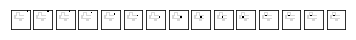

In [636]:
plot(frames)

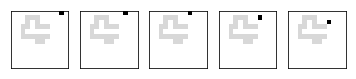

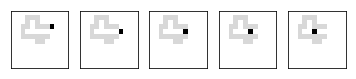

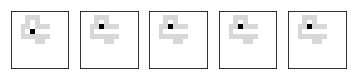

In [637]:
for i in range( len(frames) // 5 ):
    plot(frames[5 * i:5 * i + 5])

In [649]:
jar_generator = lambda size: generate_jar_misleading_shape_frame(size, rec_width_range = list(range(1,4)), 
                  rec_height_range = list(range(1,4)))
jar_X, jar_y = generate_examples(12, 15, 500, jar_generator)

In [650]:
loss, acc = model.evaluate(jar_X, jar_y, verbose=0)
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 0.260880, acc: 87.000000


In [651]:
wrongs = []
for i in range(100):
    loss, acc = model.evaluate(jar_X[i:i+1], jar_y[i:i+1], verbose=0)
    if acc == 0:
        wrongs.append(i)

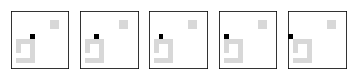

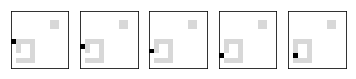

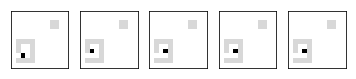

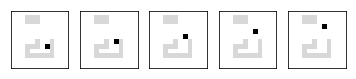

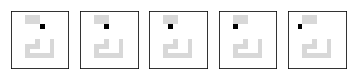

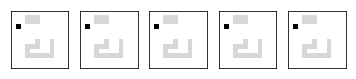

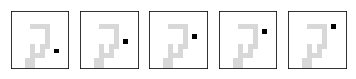

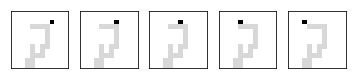

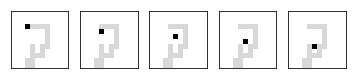

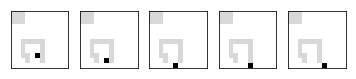

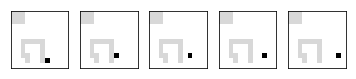

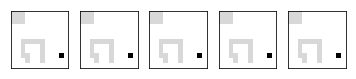

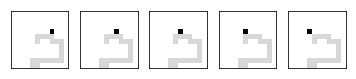

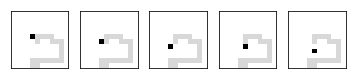

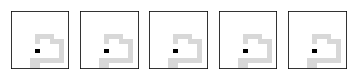

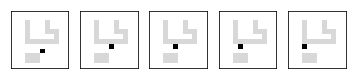

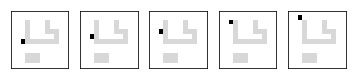

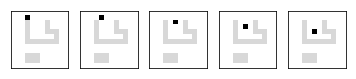

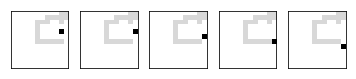

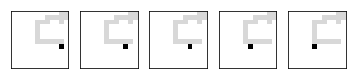

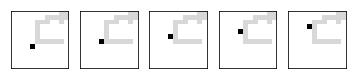

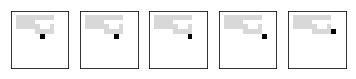

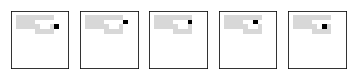

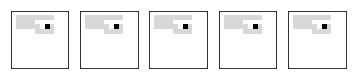

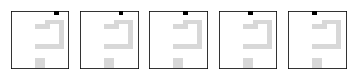

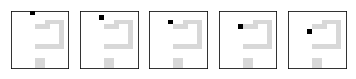

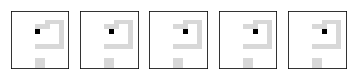

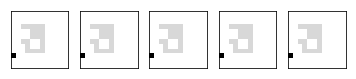

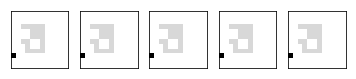

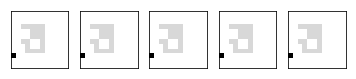

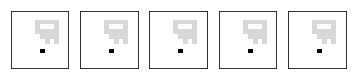

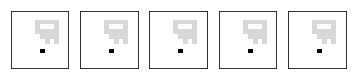

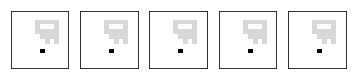

In [652]:
for wrong in wrongs:
    print ("=============")
    for i in range( len(jar_X[wrong]) // 5 ):
        plot(jar_X[wrong][5 * i:5 * i + 5])

In [548]:
loss, acc = model.evaluate(jar_X[10:11], jar_y[10:11], verbose=4)
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 3.041852, acc: 0.000000


In [1098]:
simple_jar_generator = lambda size: generate_jar_shape_frame(size)

In [1132]:
test_samples_2 = generate_example_progress_diff_len(12, 15, 500, lambda size: generate_u_shape_frame(size))
total_sample = 0
total_loss = 0
for X_evaluate, y_progress_evaluate in test_samples_2:
    if 6 <= X_evaluate[0].shape[0] <= 16:
        total_sample += len(X_evaluate)
        loss = c.model.evaluate(X_evaluate, y_progress_evaluate, verbose=2)
        total_loss += loss * len(X_evaluate)
        print('sample: %d, loss: %f' % (len(X_evaluate), loss))
print('Total loss: %f' % (total_loss / total_sample))

sample: 31, loss: 0.172518
sample: 38, loss: 0.140085
sample: 40, loss: 0.114100
sample: 56, loss: 0.093141
sample: 61, loss: 0.073495
sample: 45, loss: 0.059425
sample: 46, loss: 0.048681
sample: 40, loss: 0.035528
sample: 43, loss: 0.021862
sample: 24, loss: 0.008950
sample: 25, loss: 0.002225
Total loss: 0.072337


In [1133]:
predicted = c.model.predict(test_samples_2[10][0][:1])
print (predicted)
print (test_samples_2[10][1][:1])

[[[0.01709841]
  [0.06818907]
  [0.12003747]
  [0.17765461]
  [0.25005165]
  [0.33359215]
  [0.39520705]
  [0.45017815]
  [0.49049366]
  [0.56224614]
  [0.55609435]
  [0.6757586 ]
  [0.7892823 ]]]
[[[0.        ]
  [0.08333333]
  [0.16666667]
  [0.25      ]
  [0.33333333]
  [0.41666667]
  [0.5       ]
  [0.58333333]
  [0.66666667]
  [0.75      ]
  [0.83333333]
  [0.91666667]
  [1.        ]]]


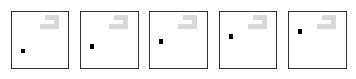

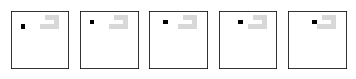

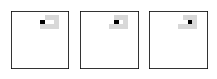

In [1134]:
plot_big(test_samples_2[10][0][0])

In [880]:
new_X, new_Y = generate_negative_sample ( test_samples[10][0][0], test_samples[10][1][0] )

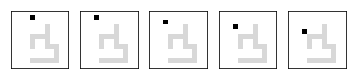

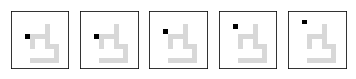

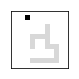

In [881]:
plot_big(new_X)

In [882]:
new_Y

array([[0. ],
       [0.1],
       [0.2],
       [0.3],
       [0.4],
       [0.5],
       [0.5],
       [0.4],
       [0.3],
       [0.2],
       [0.1]])

In [794]:
len(test_samples[10][0][0])

11

In [962]:
def get_next_pos ( pos, movement ) :
    if movement == 0:
        # North
        return (pos[0] - 1, pos[1])
    
    if movement == 1:
        # East
        return (pos[0], pos[1] + 1)
    
    if movement == 2:
        # South
        return (pos[0] + 1, pos[1])
    
    if movement == 3:
        # West
        return (pos[0], pos[1] - 1)

def get_sequence ( frames, pos, movement ):
    last_frame = frames[-1]
    
    next_pos = get_next_pos ( pos , movement)
    
    new_frame = last_frame.copy()
    new_frame[pos] = 0
    new_frame[next_pos] = 4
    
    new_frames = list(frames)
    new_frames.append(new_frame)
    
    return new_frames, next_pos
    
def get_sequence_from_beginning ( start_frame, start_pos, movements ):
    """
    From a sample (with imprinted moving agent at start_pos)
    and movement of the agent.
    
    Return:
    frames: the frame sequences
    pos: last position of moving agent
    """
    pos = start_pos
    frames = [start_frame]
    
    for movement in movements:
        frames, pos = get_sequence (frames, pos, movement)
    
    return frames, pos

def search_enter ( sample , start_pos, size, no_peep = True ):
    """
    sample is a sequence of frames from start to end
    
    We gonna run a searching algorith again for the starting frame based on the 
    current learning model.
    """
    
    # Keep maximumly 100 last explored sequences
    max_explore = 200
    
    start_frame = sample[0]
    
    # At the start, we have only one element to explore, which is an empty list (the start position)
    # The progress is by default 0
    explorations = [ ([], 0) ]
    
    # We will update this value after each searching step
    # We will stop if max_p doesn't increase anymore
    max_p = 0
    
    no_progress_counter = 0
    
    # At each time, we add the movement of the element into the exploration
    # North = 0, East = 1, South = 2, West = 3
    for i in range(30):
#         print (explorations)
        # This is to replace explorations
        new_explorations = []
        
        # This is to run LSTM algorithm on
        new_explorations_frames = []
        for e, _ in explorations:
            frames, pos = get_sequence_from_beginning ( start_frame , start_pos, e )
            
            for movement in range(4):
                next_pos = get_next_pos ( pos, movement )
                if check_in_frame( size , next_pos ) and (frames[-1][next_pos] == 0 or not no_peep)\
                   and (len(e) == 0 or (movement - e[-1]) % 4 != 2):
                    new_frames, _ = get_sequence ( frames, pos, movement )
                    
                    new_e = list (e)
                    new_e.append(movement)
                    
                    new_explorations.append ( new_e )
                    new_explorations_frames.append(new_frames)
        
        X = array(new_explorations_frames).reshape(len(new_explorations_frames), i + 2, size, size, 1)
        
        # ( #Pattern, i + 2, 1)
        predicted = c.model.predict( X )
        
        predicted_last_step = predicted[:, -1, 0]
#         print (predicted_last_step)
        
        explorations = [ (new_e, new_p) for new_e, new_p in zip (new_explorations, predicted_last_step) ]
        
        explorations = sorted(explorations, key = lambda k : k[1], reverse = True)
        
        explorations = explorations [ : max_explore ]
        
        if max_p < explorations[0][1]:
            max_p = explorations[0][1]
            no_progress_counter = 0
        else:
            no_progress_counter += 1
            # No more progress
            print ('No more progres')
            
            if (no_progress_counter >= 3):
                """ One more try"""
                break
    
    best_frames, last_pos = get_sequence_from_beginning (  start_frame , start_pos, explorations[0][0] ) 
    best_p = explorations[0][1]
    return (best_frames, best_p)

In [1003]:
def get_start_pos( sample ):
    return get_pos ( sample, 0 )

def get_pos( sample, index ):
    """
    Get position of the moving point of the frame from sample
    """
    frame = sample[index]
    
    start_pos = np.where (frame == 4 )
    return (start_pos[0][0], start_pos[1][0])

In [815]:
size = 12

In [1189]:
sample_index = 0
sample = test_samples_2[10][0][sample_index][:,:,:,0]

In [1190]:
start_pos = get_start_pos (sample)

In [1191]:
best_frames, best_p = search_enter ( sample , start_pos, size, no_peep = True )

No more progres
No more progres
No more progres


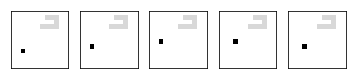

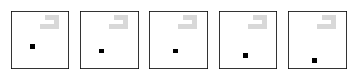

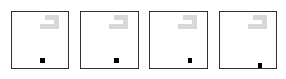

In [1192]:
plot_big (best_frames)

In [1188]:
best_p

0.99726033

In [943]:
t = best_frames[0].copy()

In [951]:
t[t == 4] = 0

In [948]:
get_start_pos(best_frames)

(1, 4)

In [950]:
path = generate_path ( frame, (1, 4), (8, 8) )

In [954]:
frames = []
for step in path:
    f = t.copy()
    f[step] = 4
    frames.append(f)

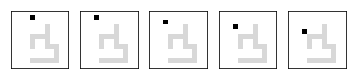

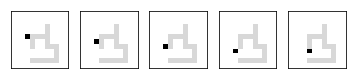

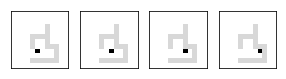

In [955]:
plot_big(frames)

In [956]:
q = array(frames).reshape ( (1, 14, 12, 12, 1))

In [994]:
c.model.predict(q).flatten()

array([0.0073579 , 0.06765842, 0.13134168, 0.19341901, 0.2748018 ,
       0.33656138, 0.39495054, 0.47948766, 0.53318924, 0.578541  ,
       0.6410687 , 0.73307055, 0.8522859 , 0.92469484], dtype=float32)